In [60]:
import torch
from load_graph import load_graph
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import SAGEConv, GraphConv, GATConv, to_hetero
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pickle
import time

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device = torch.device('cpu')

train_data, val_data, test_data, trust_data = load_graph('data/all_pos_data.csv', 'data/train_data.csv', 'data/testidation_data.csv', 'data/test_data.csv', 'data/trust.csv')
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
trust_data = trust_data.to(device)


HeteroData(
  user={ x=[335, 335] },
  (user1, trusts, user2)={ edge_index=[2, 2084] },
  (user2, rev_trusts, user1)={ edge_index=[2, 2084] }
)


Batches:   0%|          | 0/324 [00:00<?, ?it/s]

In [123]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        return x
    
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(3 * hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['item'][col]], dim=-1)
        z = self.bn1(self.lin1(z)).relu()
        z = F.dropout(z, p=0.5, training=self.training)
        z = self.lin2(z)
        z = 4*self.sigmoid(z) + 1

        return z.view(-1)
    
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, metadata):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, metadata, aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)
        self.encoder_social = GNNEncoder(hidden_channels, hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index, edge_index_dict_social):
        z_dict = self.encoder(x_dict, edge_index_dict)
        social_embedding = self.encoder_social(x_dict['user'], edge_index_dict_social)
        z_dict['user'] = torch.cat([z_dict['user'], social_embedding], dim=-1)
        return self.decoder(z_dict, edge_label_index), z_dict['user']

In [129]:
def train(model, train_data, optimizer, criterion, trust_data):
    model.train()
    optimizer.zero_grad()
    pred, _ = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'item'].edge_label_index, trust_data['user1', 'user2'].edge_index)
    target = (train_data['user', 'item'].edge_label).float()
    loss = criterion(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

def test(model, data, trust_data):
    model.eval()
    with torch.no_grad():
        pred, _ = model(data.x_dict, data.edge_index_dict,
                    data['user', 'item'].edge_label_index, trust_data['user1', 'user2'].edge_index)
        
        target = data['user', 'item'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        num_correct = torch.sum(torch.abs(pred - target) < 0.5).item()
    return float(rmse), num_correct / len(target)

In [130]:
def train_loop(model, train_data, val_data, test_data, trust_data, optimizer, epochs, criterion, save_path):
    writer = tf.summary.create_file_writer(f'runs_rating/{save_path}')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    test_losses = []
    test_accuracies = []
    for epoch in tqdm(range(epochs)):
        train_loss = train(model, train_data, optimizer, criterion, trust_data)
        train_losses.append(train_loss)
        _, train_accuracy = test(model, train_data, trust_data)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = test(model, val_data, trust_data)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        test_loss, test_accuracy = test(model, test_data, trust_data)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        with writer.as_default():
            tf.summary.scalar('Loss/train', train_loss, step=epoch+1)
            tf.summary.scalar('Loss/val', val_loss, step=epoch+1)
            tf.summary.scalar('Loss/test', test_loss, step=epoch+1)
            tf.summary.scalar('Accuracy/train', train_accuracy, step=epoch+1)
            tf.summary.scalar('Accuracy/val', val_accuracy, step=epoch+1)
            tf.summary.scalar('Accuracy/test', test_accuracy, step=epoch+1)

    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies

In [159]:
hidden_channels = 128
lr = 0.01
epochs = 50
conv = 'SAGEConv'
num_layers = 2
social = 'True'
isTest = 'True'
criterion = nn.MSELoss()
save_path = f'hidden_channels-{hidden_channels}_lr-{lr}_epochs-{epochs}_conv-{conv}_social-{social}_num_layers-{num_layers}'

model = Model(hidden_channels=hidden_channels, metadata=train_data.metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


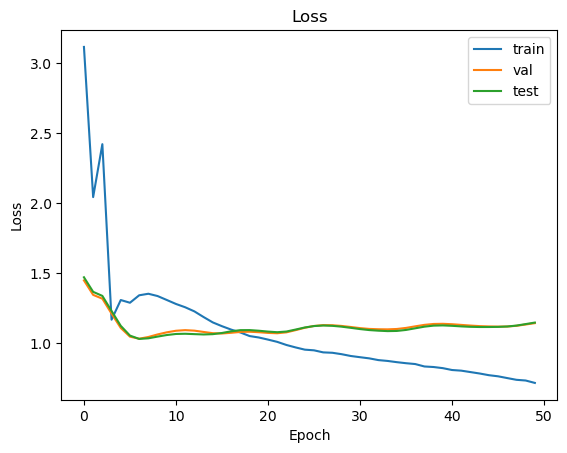

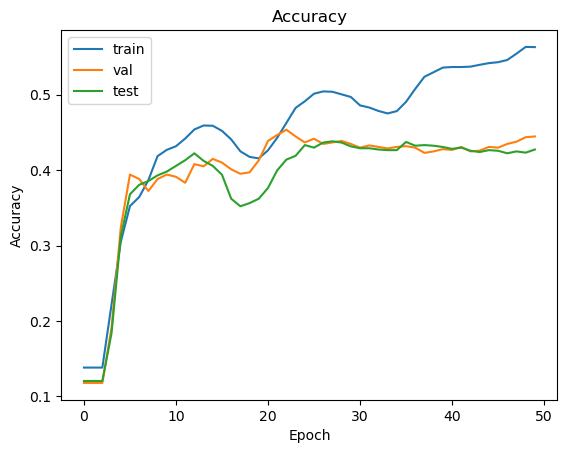

In [160]:
os.makedirs(f'runs_rating/{save_path}')

train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train_loop(model, train_data, val_data, test_data, trust_data, optimizer, epochs, criterion, save_path)

with open(f'runs_rating/{save_path}/data.pkl', 'wb') as f:
    pickle.dump({'train_losses': train_losses, 
                 'train_accs': train_accuracies, 
                 'val_losses': val_losses, 
                 'val_accs': val_accuracies, 
                 'test_losses': test_losses, 
                 'test_accs': test_accuracies, 
                 'model': model}, f)
    
time.sleep(1)

# Plot and save results
with open(f'runs_rating/{save_path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    model = data['model']
    train_losses = data['train_losses']
    train_accs = data['train_accs']
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    test_losses = data['test_losses']
    test_accs = data['test_accs']

plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.plot(test_losses, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.savefig(f'runs_rating/{save_path}/loss.png')

plt.figure()
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.plot(test_accs, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.savefig(f'runs_rating/{save_path}/accuracy.png')


In [205]:
# Load model for testing/demonstration
test_path = f'hidden_channels-64_lr-0.01_epochs-50_conv-SAGEConv_social-True_num_layers-2_isTest-True'
with open(f'runs_rating/{test_path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    test_model = data['model']

sample_edge_label_index = test_data['user', 'item'].edge_label_index

test_model.eval()
with torch.no_grad():
    pred, user_embed = model(train_data.x_dict, test_data.edge_index_dict,
                    sample_edge_label_index, trust_data['user1', 'user2'].edge_index)
    
cos = nn.CosineSimilarity(dim=0)
num_users = user_embed.shape[0]

print(cos(user_embed[0], user_embed[118]))
print(cos(user_embed[0], user_embed[43]))

degree0 = test_data['user', 'item'].edge_index[1, (test_data['user', 'item'].edge_index[0] == 0).squeeze()]
degree43 = test_data['user', 'item'].edge_index[1, (test_data['user', 'item'].edge_index[0] == 43).squeeze()]
degree118 = test_data['user', 'item'].edge_index[1, (test_data['user', 'item'].edge_index[0] == 118).squeeze()]
print(len(degree0))
print(len(degree43))
print(len(degree118))


tensor(0.9513)
tensor(-0.2567)
45
31
18
tensor([178, 192])
tensor([296, 161,  76, 228, 153,  75, 121, 285, 237, 165, 255, 191, 292, 178,
        171, 193, 208, 320, 130, 100, 201, 236, 203, 273,  58, 122, 321, 241,
         67, 116,  91, 256, 154, 140, 266, 134, 156, 206, 213,  89])
tensor([143])
tensor([[   0,    0,    0,  ...,  334,  334,  334],
        [   0,    1,    2,  ..., 8016, 8017, 8018]])


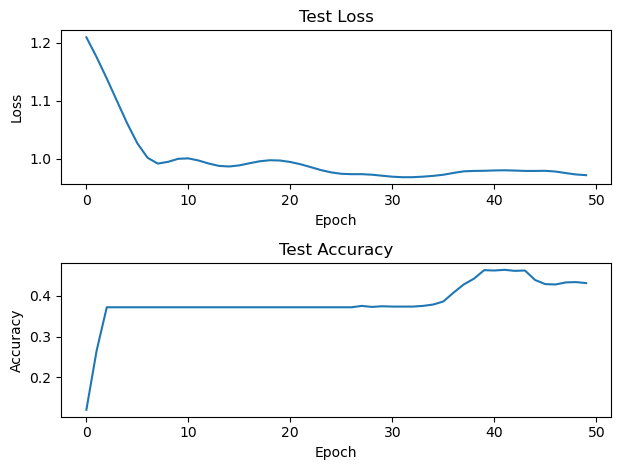

In [193]:
# Load best model with test accuracy and loss
fig, axs = plt.subplots(2)
ax1, ax2 = axs

path = f'runs_rating/8_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
        data = pickle.load(f)
        test_losses = data['test_losses']
        test_accs = data['test_accs']
        ax1.plot(test_losses, label='Loss')
        ax2.plot(test_accs, label='Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Test Loss')
ax2.set_title('Test Accuracy')
plt.tight_layout()
plt.savefig(f'test_plots/test_results.png')

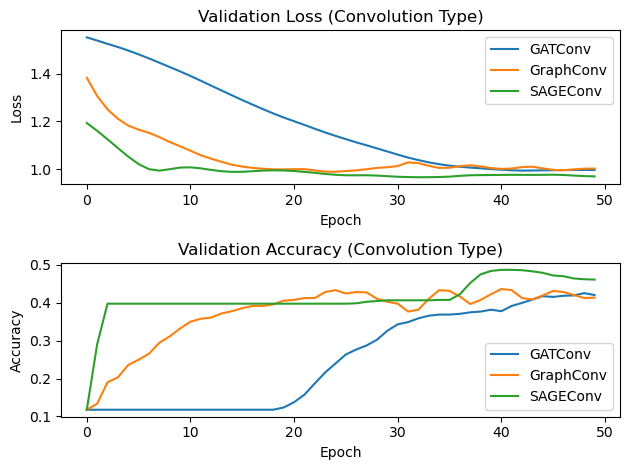

In [197]:
# Produce hyperparameter tuning results for convolution type

convs = ['GATConv', 'GraphConv']
fig, axs = plt.subplots(2)
ax1, ax2 = axs
for conv in convs:
    path = f'runs_rating/hidden_channels-8_lr-0.01_epochs-50_conv-{conv}_social-True_num_layers-2'
    with open(f'{path}/data.pkl', 'rb') as f:
        data = pickle.load(f)
        val_losses = data['val_losses']
        val_accs = data['val_accs']
        ax1.plot(val_losses, label=conv)
        ax2.plot(val_accs, label=conv)

path = f'runs_rating/8_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
        data = pickle.load(f)
        val_losses = data['val_losses']
        val_accs = data['val_accs']
        ax1.plot(val_losses, label='SAGEConv')
        ax2.plot(val_accs, label='SAGEConv')

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss (Convolution Type)')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy (Convolution Type)')
plt.tight_layout()
plt.savefig('test_plots/conv.png')
        


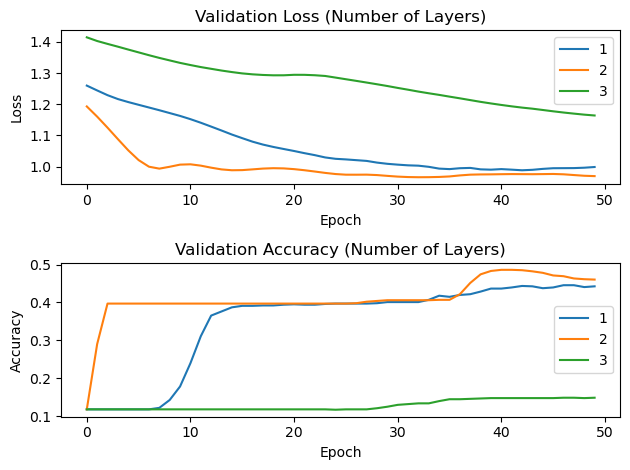

In [196]:
# Produce hyperparameter tuning results for number of layers

num_layers = [1, 3]
fig, axs = plt.subplots(2)
ax1, ax2 = axs

path = f'runs_rating/hidden_channels-8_lr-0.01_epochs-50_conv-SAGEConv_social-True_num_layers-1'
with open(f'{path}/data.pkl', 'rb') as f:
        data = pickle.load(f)
        val_losses = data['val_losses']
        val_accs = data['val_accs']
        ax1.plot(val_losses, label='1')
        ax2.plot(val_accs, label='1')

path = f'runs_rating/8_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
        data = pickle.load(f)
        val_losses = data['val_losses']
        val_accs = data['val_accs']
        ax1.plot(val_losses, label='2')
        ax2.plot(val_accs, label='2')

path = f'runs_rating/hidden_channels-8_lr-0.01_epochs-50_conv-SAGEConv_social-True_num_layers-3'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='3')
    ax2.plot(val_accs, label='3')

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss (Number of Layers)')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy (Number of Layers)')
plt.tight_layout()
plt.savefig('test_plots/num_layers.png')

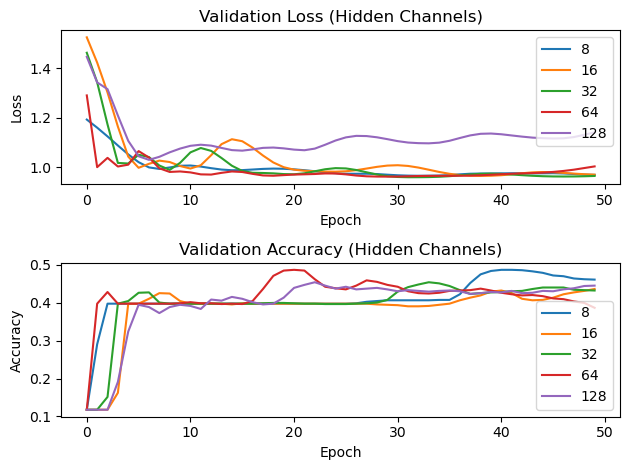

In [195]:
# Produce hyperparameter tuning results for hidden channels

fig, axs = plt.subplots(2)
ax1, ax2 = axs

path = f'runs_rating/8_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='8')
    ax2.plot(val_accs, label='8')

path = f'runs_rating/16_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='16')
    ax2.plot(val_accs, label='16')

path = f'runs_rating/32_0.01_50_SAGEConv_True'
# path = f'runs_rating/hidden_channels-32_lr-0.01_epochs-50_conv-SAGEConv_social-True_num_layers-2'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='32')
    ax2.plot(val_accs, label='32')

path = f'runs_rating/hidden_channels-64_lr-0.01_epochs-50_conv-SAGEConv_social-True'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='64')
    ax2.plot(val_accs, label='64')

path = f'runs_rating/hidden_channels-128_lr-0.01_epochs-50_conv-SAGEConv_social-True_num_layers-2'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='128')
    ax2.plot(val_accs, label='128')

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss (Hidden Channels)')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy (Hidden Channels)')
plt.tight_layout()
plt.savefig('test_plots/hidden_channels.png')


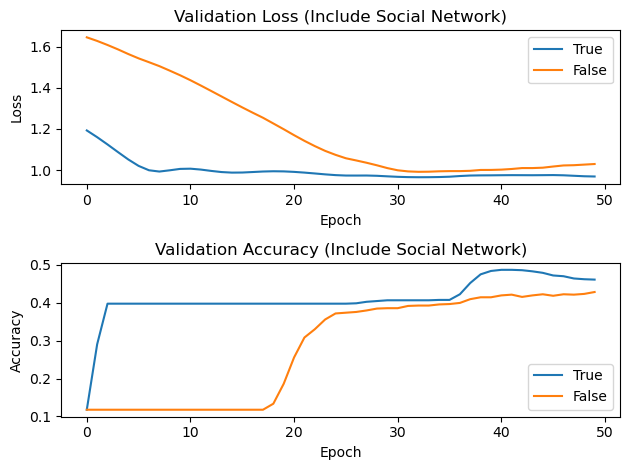

In [194]:
# Produce hyperparameter tuning results for presence of social network

fig, axs = plt.subplots(2)
ax1, ax2 = axs

path = f'runs_rating/8_0.01_50_SAGEConv_True'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='True')
    ax2.plot(val_accs, label='True')

path = f'runs_rating/hidden_channels-8_lr-0.01_epochs-50_conv-SAGEConv_social-False_num_layers-2'
with open(f'{path}/data.pkl', 'rb') as f:
    data = pickle.load(f)
    val_losses = data['val_losses']
    val_accs = data['val_accs']
    ax1.plot(val_losses, label='False')
    ax2.plot(val_accs, label='False')

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Validation Loss (Include Social Network)')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy (Include Social Network)')
plt.tight_layout()
plt.savefig('test_plots/social.png')